In [1]:
import torch
from HopfieldNetworkPyTorch.ModernHopfieldNetwork import ModernHopfieldNetwork, InteractionFunction
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

if not torch.cuda.is_available():
    print("WARNING: This script can take a substantial amount of time without a GPU!")

In [2]:
numClasses = 10
imageShape = (28, 28)

IMAGE_THRESHOLD = 0.5

# Get the MNIST dataset

trainingData = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

X_train = torch.flatten(trainingData.data, start_dim=1).T
X_train = X_train / 255.0
X_train[X_train < IMAGE_THRESHOLD] = -1
X_train[X_train > IMAGE_THRESHOLD] = 1
y_train = torch.full((trainingData.targets.shape[0], numClasses), -1)       # Creates a new vector of -1 for each item in the training data
y_train = y_train.scatter(1, trainingData.targets.view(-1,1), 1).T          # Puts a 1 at the correct class index for each vector, now one hot encoded
trainingStates = torch.cat((X_train, y_train))                              # Finally, put the image data and class data together into a single tensor
del X_train
del y_train
del trainingData

testingData = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

X_test = torch.flatten(testingData.data, start_dim=1).T
X_test = X_test / 255.0
X_test[X_test < IMAGE_THRESHOLD] = -1
X_test[X_test > IMAGE_THRESHOLD] = 1
y_test = torch.full((testingData.targets.shape[0], numClasses), -1)      # Creates a new vector of -1 for each item in the testing data
y_test = y_test.scatter(1, testingData.targets.view(-1,1), 1).T          # Puts a 1 at the correct class index for each vector, now one hot encoded
testingStates = torch.cat((X_test, y_test))                              # Finally, put the image data and class data together into a single tensor
del X_test
del y_test
del testingData

In [175]:
# Dimension of our network will be the flattened image shape (28*28) plus a number of neurons equal to the number of classes (10)
dimension = (imageShape[0] * imageShape[1])+numClasses

# Since we will not update the "image neurons" we mask only the "class neurons"
neuronMask = torch.arange(dimension-10, dimension)

# We must also set the various ModernHopfieldNetwork parameters

numMemories = 100
interactionVertex = 3
initialLearningRate = 5e-2
learningRateDecay = 0.999
momentum = 0.6
initialTemperature = 250
finalTemperature = 100
errorPower = 1

maximumTrainingEpochs = 2500
itemBatchSize = 1024
neuronBatchSize = 10


In [176]:
network = ModernHopfieldNetwork(
    dimension = dimension,
    nMemories = numMemories,
    interactionFunction = InteractionFunction.RectifiedPolynomialInteractionFunction(interactionVertex),
    torchDevice = device,
    itemBatchSize = itemBatchSize,
    neuronBatchSize = neuronBatchSize 
)

newMemories = torch.normal(mean=torch.full_like(network.memories, -0.3))
newMemories = newMemories.clamp_(-1,1)
network.setMemories(newMemories)

In [177]:
# Learn the memory vectors

trainingStates = trainingStates[:, :2**14]

history = network.learnMemories(
    trainingStates.to(device),
    maxEpochs = maximumTrainingEpochs, 
    initialLearningRate = initialLearningRate,
    learningRateDecay = learningRateDecay,
    momentum = momentum,
    initialTemperature = initialTemperature,
    finalTemperature = finalTemperature,
    errorPower = errorPower,
    neuronMask = neuronMask,
    precision=0,
    verbose=2,
)

Epoch 0000: Loss 0.8164924621582031
Epoch 0001: Loss 0.7874658584594727
Epoch 0002: Loss 0.7594194412231445
Epoch 0003: Loss 0.7324029445648194
Epoch 0004: Loss 0.7061953067779541
Epoch 0005: Loss 0.6807629108428955
Epoch 0006: Loss 0.6562996864318847
Epoch 0007: Loss 0.6328584671020507
Epoch 0008: Loss 0.6104456901550293
Epoch 0009: Loss 0.5889604568481446
Epoch 0010: Loss 0.568431043624878
Epoch 0011: Loss 0.5490473747253418
Epoch 0012: Loss 0.5307560920715332
Epoch 0013: Loss 0.5135080814361572
Epoch 0014: Loss 0.4973732948303223
Epoch 0015: Loss 0.4823880195617676
Epoch 0016: Loss 0.4685207843780518
Epoch 0017: Loss 0.4558406352996826
Epoch 0018: Loss 0.44426746368408204
Epoch 0019: Loss 0.4337887763977051
Epoch 0020: Loss 0.42435216903686523
Epoch 0021: Loss 0.41585578918457033
Epoch 0022: Loss 0.40828661918640136
Epoch 0023: Loss 0.40157623291015626
Epoch 0024: Loss 0.395679235458374
Epoch 0025: Loss 0.3905390739440918
Epoch 0026: Loss 0.3860599994659424
Epoch 0027: Loss 0.382206

In [179]:
relaxedTestingStates = testingStates.clone().to(device)
relaxedTestingStates[-numClasses:, :] = -1
network.stepStates(relaxedTestingStates, neuronMask=neuronMask, activationFunction=lambda X: X)
relaxedTestingStates = relaxedTestingStates.to("cpu")

In [180]:
display(trainingStates[-numClasses:,:10])
display(testingStates[-numClasses:,:10])
display(torch.nn.Softmax(dim=0)(relaxedTestingStates[-numClasses:,:10]))

tensor([[-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1.],
        [-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.],
        [-1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.],
        [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.]])

tensor([[-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.],
        [-1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.]])

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])

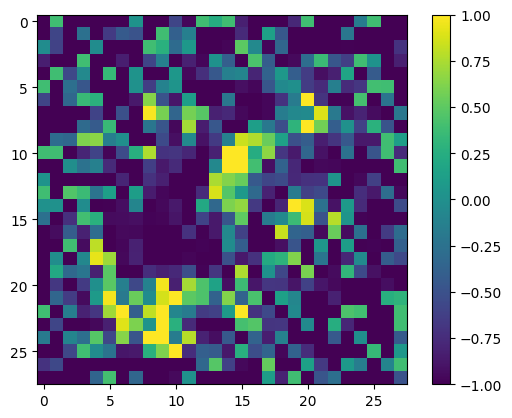

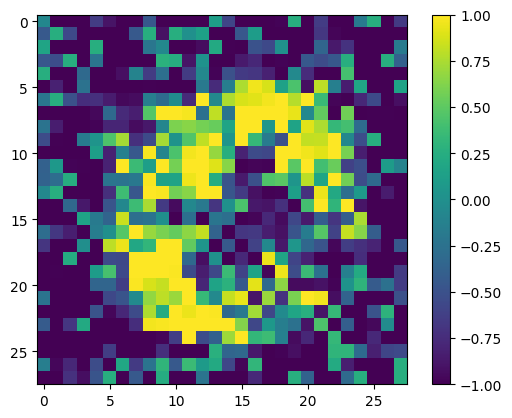

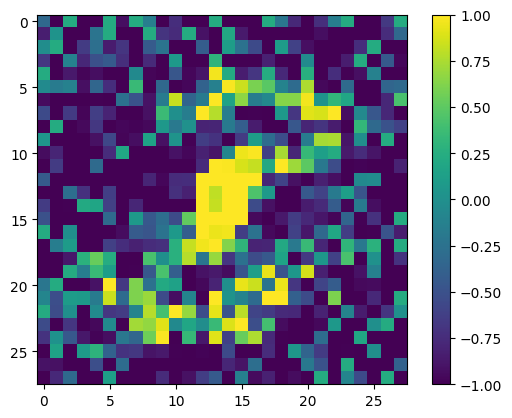

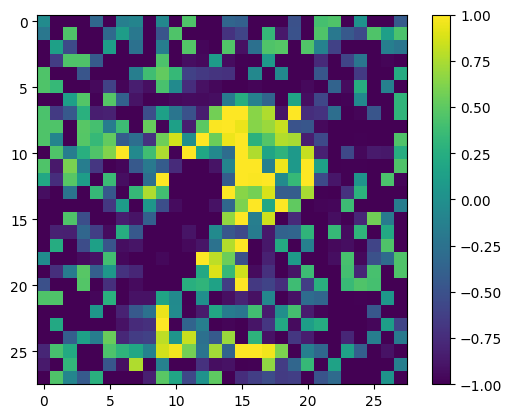

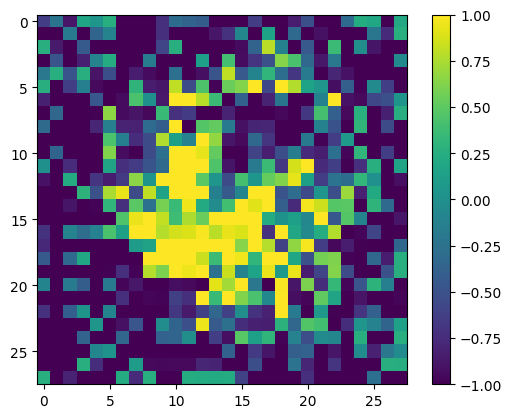

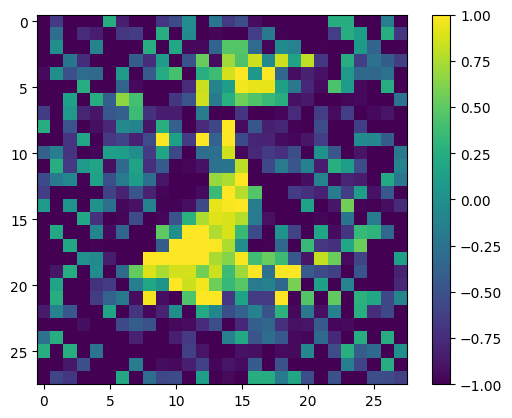

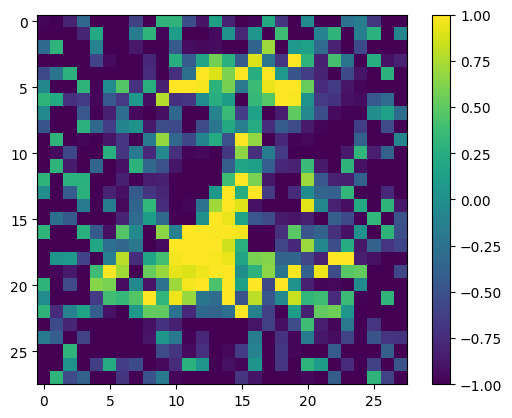

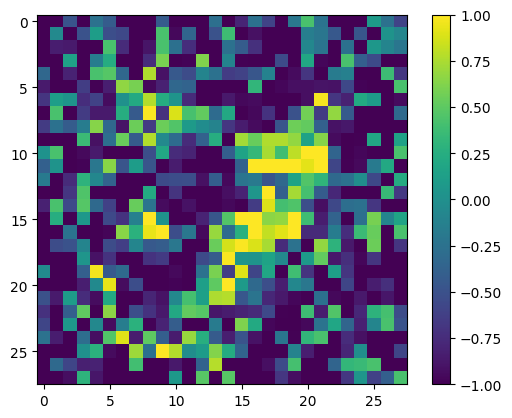

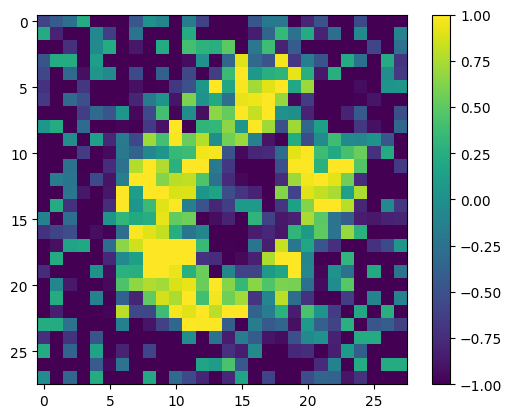

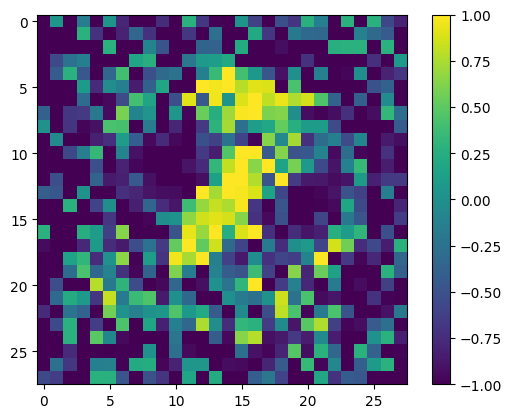

In [181]:
t = network.memories
# t = trainingStates
# t = testingStates

for i in range(10):
    targetMemory = t[:784, i].to("cpu").detach().numpy()
    targetMemory = targetMemory.reshape(imageShape)
    plt.imshow(targetMemory)
    plt.colorbar()
    plt.show()